In [ ]:
#Current Definition of Impaired

    IM_idx = list(set([i[0] for i in Occ_DF[(Occ_DF.PER_TYPE==1) & (Occ_DF.DR_CON.isin([2,3,6,7]))].index]))
    EADict.update({'EA_IM':IM_idx})

In [2]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import scipy
from matplotlib.gridspec import GridSpec
from mailmerge import MailMerge
import shutil
import openpyxl
from scipy.optimize import curve_fit
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-20 15:34:48


In [ ]:
DB_Dir = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\9.0_IL_SafetyDB'
print(strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
#Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.DataFrame()
Veh_DF = pd.DataFrame()
Occ_DF = pd.DataFrame()
for year in range(2005,2017):
    df = pd.read_csv(DB_Dir+'\\{}_Crash_Assigned.csv'.format(year),index_col=0)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['YEAR'] = year
    Crash_DF = pd.concat([Crash_DF,df])
    df = pd.read_csv(DB_Dir+'\\{}_Vehicle_Cleaned_EA.csv'.format(year),index_col=[0,1])
    df['YEAR'] = year
    Veh_DF = pd.concat([Veh_DF,df])
    df = pd.read_csv(DB_Dir+'\\{}_Person_Cleaned_EA.csv'.format(year),index_col=[0,1,2], encoding='latin-1',low_memory=False)
    df['DOB'] = pd.to_datetime(df['DOB'])
    df['YEAR'] = year
    Occ_DF = pd.concat([Occ_DF,df])
    print(year)
print(Crash_DF.shape,Veh_DF.shape,Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
# Read All Ks and As from 2005 to 2016
print(strftime("%Y-%m-%d %H:%M:%S"))
K_Crash_DF = pd.read_csv('K_Crash_05_16.csv',index_col=0)
K_Veh_DF = pd.read_csv('K_Veh_05_16.csv',index_col=[0,1],low_memory=False)
K_Occ_DF = pd.read_csv('K_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
print(K_Crash_DF.shape,K_Veh_DF.shape,K_Occ_DF.shape)
A_Crash_DF = pd.read_csv('A_Crash_05_16.csv',index_col=0)
A_Veh_DF = pd.read_csv('A_Veh_05_16.csv',index_col=[0,1],low_memory=False)
A_Occ_DF = pd.read_csv('A_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
K_Crash_DF['DATE'] = pd.to_datetime(K_Crash_DF['DATE'])
A_Crash_DF['DATE'] = pd.to_datetime(A_Crash_DF['DATE'])
K_Occ_DF['DOB'] = pd.to_datetime(K_Occ_DF['DOB'])
A_Occ_DF['DOB'] = pd.to_datetime(A_Occ_DF['DOB'])
print(A_Crash_DF.shape,A_Veh_DF.shape,A_Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-20 15:34:48
(11510, 56) (17049, 40) (29143, 35)
(126492, 56) (205139, 40) (334237, 35)
2018-11-20 15:35:02


In [ ]:
# Check Summations
print(strftime("%Y-%m-%d %H:%M:%S"))
display(K_Crash_DF.groupby(['YEAR'])['K','A','B','C','O'].aggregate(sum))
df1 = pd.DataFrame(K_Occ_DF.groupby(['YEAR','INJ_SEV']).size())
df1 = df1.unstack()
df1.columns = ['O','C','B','A','K']
df1 = df1[['K','A','B','C','O']]
display(df1)

In [ ]:
#Check with SHSP 2088 Ks from 2010 to 2014
print(strftime("%Y-%m-%d %H:%M:%S"))
K_Occ_DF[K_Occ_DF.YEAR.isin(range(2010,2015)) & (K_Occ_DF.EA_IM==1)]['INJ_SEV'].value_counts()

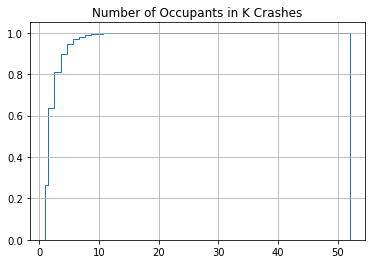

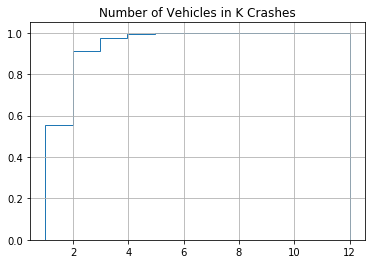

In [18]:
# Check for number of Occ and Veh
K_Occ_DF.CID = pd.Series(K_Occ_DF.index.droplevel([1,2]),index=K_Occ_DF.index)
#K_Occ_DF.CID.value_counts()
plt.hist(K_Occ_DF.CID.value_counts(),bins=100,cumulative=True, density=True, histtype='step')
plt.grid()
plt.title('Number of Occupants in K Crashes')
plt.show()

K_Veh_DF.CID = pd.Series(K_Veh_DF.index.droplevel([1]),index=K_Veh_DF.index)
plt.hist(K_Veh_DF.CID.value_counts(),bins=100,cumulative=True, density=True, histtype='step')
plt.grid()
plt.title('Number of Vehicles in K Crashes')
plt.show()

In [3]:
print(strftime("%Y-%m-%d %H:%M:%S"))
def CrashCart(CID,K_Crash_DF,K_Veh_DF,K_Occ_DF):
    def DrawTable(df,col_width=0.7):
        n_col  = df.shape[1]
        n_rows = df.shape[0]
        t = plt.table(cellText=list(df.values), cellColours=None,
              cellLoc='left',colWidths=[col_width]*n_col,
              rowLabels=list(df.index), rowColours=['yellow']*n_rows, rowLoc='left',
              colLabels=df.columns, colColours=None, colLoc='left',
              loc='center', bbox=None)
        t.scale(1, 1.3)
        t.auto_set_font_size(False)
        t.set_fontsize(12)
        plt.gca().axis('off')
        #plt.tight_layout()
        #plt.show()

    plt.figure(figsize=(30,16))
    plt.subplots_adjust(wspace=0, hspace=0)

    C_F = ['DATE','TWAY_DESC','TCONT_DEV','TCONT_CON','SURF_CON', 'ALIGN', 'DEFECT', 'LIGHT', 'SUN_ANG', 'WEATHER', 'COL_TYPE', 'CAUSE_1', 'CAUSE_2']
    C_F2 = ['INT_REL', 'HIT_RUN','WZ_OCCUR']
    for f in C_F2:
        if K_Crash_DF.loc[CID,f]==1:
            C_F.append(f)
    cdf = pd.DataFrame()
    for f in C_F:
        try:
            a = getattr(hsmpy3.il.domains,f)['alias']
        except:
            a = f
        try:
            v = getattr(hsmpy3.il.domains,f)['codes'][K_Crash_DF.loc[CID,f]]
        except:
            v = K_Crash_DF.loc[CID,f]
        cdf.loc[CID,a] = v
    EAs = ['RD','IM','UO','IN','SA','OD','YD','MC','HV','PD','PC','WZ','DF','TN']
    cdf.loc[CID,'EAs'] = ''
    for ea in EAs:
        if K_Crash_DF.loc[CID,'EA_{}'.format(ea)]==1:
            cdf.loc[CID,'EAs'] = cdf.loc[CID,'EAs'] + ea + ';'
    n = max(list(K_Occ_DF.loc[CID].index.droplevel(1)))
    m = []
    for i in range(1,n+1):
        m.append(K_Occ_DF.loc[(CID,i)].shape[0])
    m = max(m)
    plt.subplot(3,1,1)
    DrawTable(pd.DataFrame(cdf.T),0.3)
    vdf = pd.DataFrame()
    C_F = ['VEHT', 'VEHU', 'MANV', 'DIRP', 'EXC_SPL', 'EVNT1', 'EVNT2', 'EVNT3', 'LOC1', 'LOC2', 'LOC3', 'MHE', 'MHE_LOC', 'MHE_NO', 'FRST_CONT', 'VEHD']
    C_F2 = ['TOW', 'FIRE_IND', 'HAZMAT', 'CV_IND']
    for f in C_F2:
        if K_Veh_DF.loc[CID,f].any()==1:
            C_F.append(f)
    for i in range(1,n+1):
        for f in C_F:
            try:
                a = getattr(hsmpy3.il.domains,f)['alias']
            except:
                a = f
            try:
                v = getattr(hsmpy3.il.domains,f)['codes'][K_Veh_DF.loc[(CID,i),f]]
            except:
                v = K_Veh_DF.loc[(CID,i),f]
            vdf.loc[i,a] = v
    plt.subplot(3,1,2)
    DrawTable(pd.DataFrame(vdf.T),0.2)
    C_F = ['PER_TYPE', 'DOB', 'AGE', 'SEX', 'INJ_SEV', 'SEAT_POS', 'SAF_EQI', 'AIRBAG', 'EJECT', 'DR_LIC_ST', 'DR_ACTION', 'DR_VISION', 'DR_CON', 'BAC', 'CELL_USE', 'PD_ACTION', 'PD_LOC', 'PD_VIS']
    n = max(list(K_Occ_DF.loc[CID].index.droplevel(1)))
    odf = pd.DataFrame()
    for i in range(1,n+1):
        m1 = K_Occ_DF.loc[(CID,i)].shape[0]
        for j in range(1,m1+1):
            for f in C_F:
                try:
                    a = getattr(hsmpy3.il.domains,f)['alias']
                except:
                    a = f
                try:
                    v = getattr(hsmpy3.il.domains,f)['codes'][K_Occ_DF.loc[(CID,i,j),f]]
                except:
                    v = K_Occ_DF.loc[(CID,i,j),f]
                odf.loc['{}_{}'.format(i,j),a] = v
    plt.subplot(3,1,3)
    DrawTable(pd.DataFrame(odf.T),0.2)
    #plt.tight_layout()
    #plt.show()
    plt.savefig('CrashCards\\CID_{}'.format(CID),transparent=False,dpi=100)
    plt.close()
    return()

2018-11-20 14:20:55
200602657911
200600000338
201501322167
201400137050
201301251183
201301054382
Failed: 200704031311
200700738497
200500330653
200500304971
201501101725
201400283896
201400108821
201400128755
201400212595
201301191636
201301024982
201201132668
201201132666
201201042445
201201024818
201101024397
201001088755
201001031656
200901121776
200901104091
200803855882
200803213942
200801145500
200800371917
200800205032
Failed: 200705413112
Failed: 200704335779
200700571922
200600001351
200600000775
200503199667
200504088646
200500412725
201601347930
201601335558
201601291650
201601283298
201601257824
201601200464
201601125982
201601068072
201601030787
201501272897
201501173209
201501088244
Failed: 201501053050
201501069101
201400304560
201400283879
201400251888
201400126862
201400056010
201400046491
201400035730
201301227966
201301251173
201301245719
201301195922
201301211263
201301156036
201301169190
201301027918
201301083563
201301014261
201201176062
201201171474
201201161676

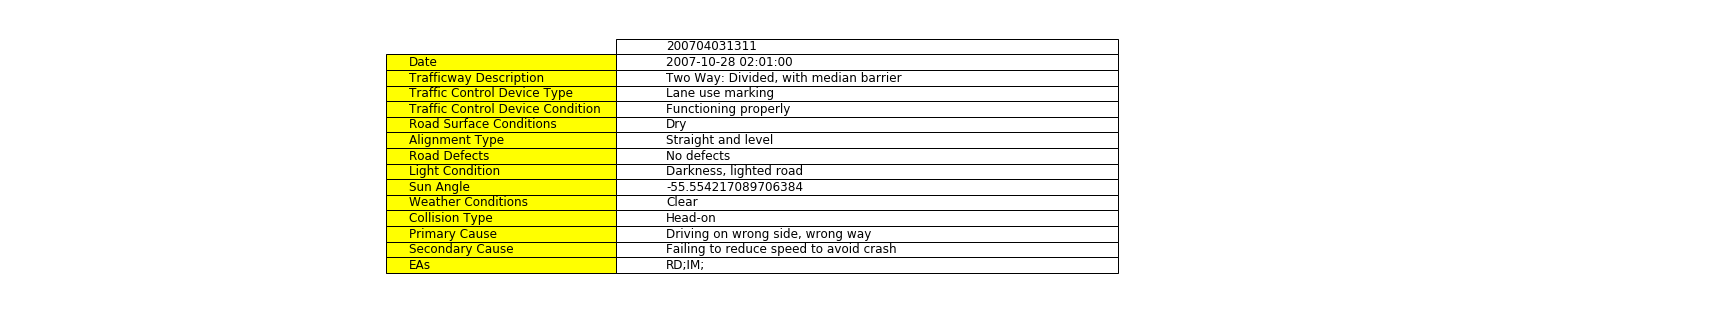

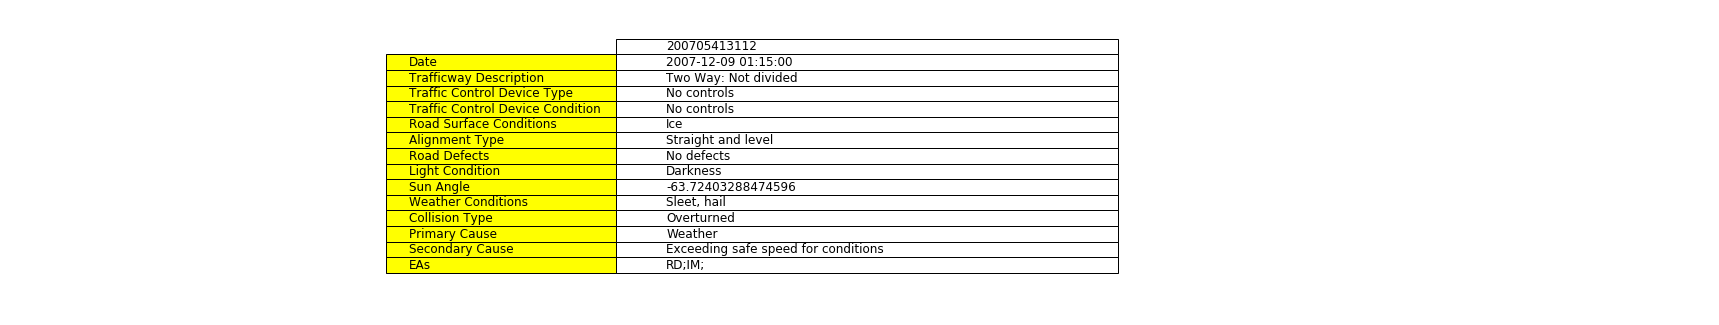

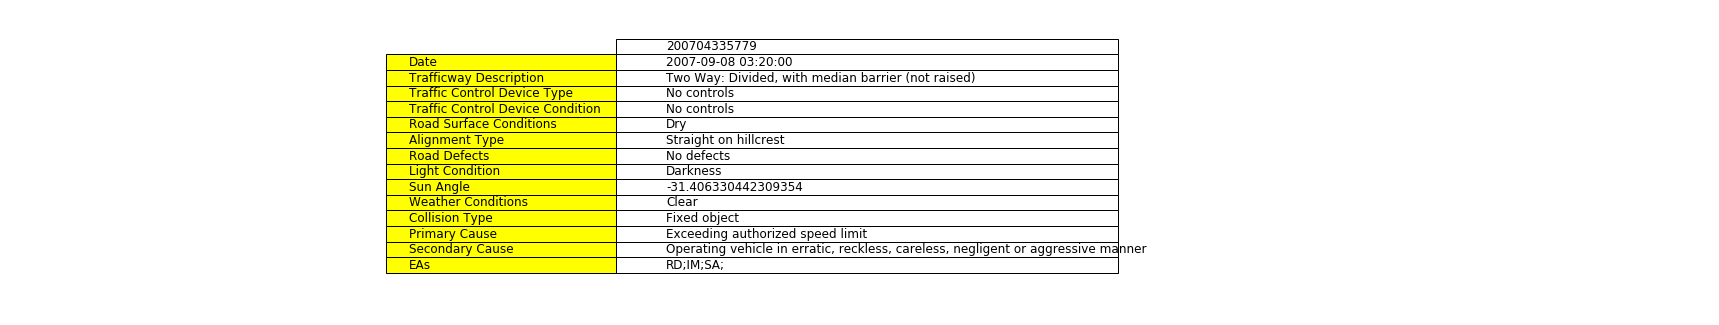

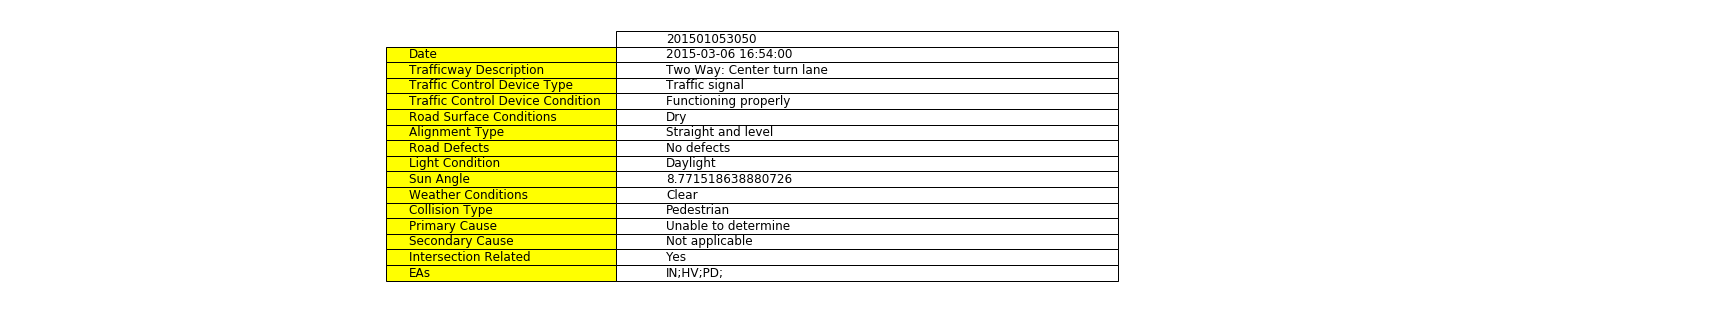

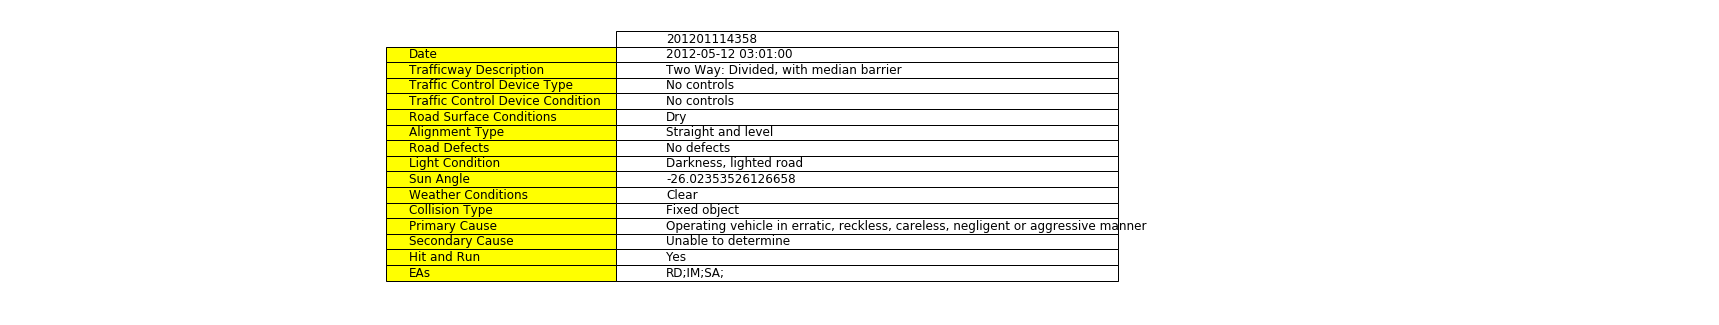

In [7]:
print(strftime("%Y-%m-%d %H:%M:%S"))
CIDs = list(K_Crash_DF.sort_values(['K','DATE'],ascending=False).index)
for CID in CIDs[0:100]:
    try:
        CrashCart(CID,K_Crash_DF,K_Veh_DF,K_Occ_DF)
        print(str(CID))
    except:
        print('Failed: ' + str(CID))
plt.close()
print(strftime("%Y-%m-%d %H:%M:%S"))